<a href="https://colab.research.google.com/github/Ayanlola2002/Data-Science-Nigeria/blob/DSN_best_car_price_prediction_2019/best_car_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [0]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dsn-recruitment-service-test

  0% 0.00/3.65M [00:00<?, ?B/s]
100% 3.65M/3.65M [00:00<00:00, 123MB/s]
 54% 5.00M/9.21M [00:00<00:00, 23.7MB/s]
100% 9.21M/9.21M [00:00<00:00, 36.2MB/s]


In [0]:
#unzippig the us-data file
from shutil import unpack_archive
#unpack_archive('all.zip')
unpack_archive('train.csv.zip')
unpack_archive('test.csv.zip')

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [0]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

In [0]:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [0]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [12]:
##display the first five rows of the train dataset.
train.head(5)

,id,seller_type,country_of_use,weblog_date,Area_address_code,car_name,car_type,Permit_registration_year,registration_month,horse_power,mileage,gas_type,car_brand,Status_of_car_repair,gear_type,date_of_advert,last_advert_online,model,naira_price
0,0,private,london,2016-03-24,66954,A5_Sportback_2.7_Tdi,coupé,2013,5,190,201125.000,diesel,audi,ja,manuell,2016-03-24,2016-04-07,NaN,6588000.000
1,1,private,london,2016-03-14,90480,"Jeep_Grand_Cherokee_""Overland""",NaN,2006,8,163,201125.000,diesel,jeep,NaN,automatik,2016-03-14,2016-04-05,grand,3528000.000
2,3,private,london,2016-03-31,60437,Skoda_Fabia_1.4_TDI_PD_Classic,small car,2010,7,69,144810.000,diesel,skoda,nein,manuell,2016-03-31,2016-04-06,fabia,1296000.000
3,4,private,london,2016-04-04,33775,BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...,limousine,1997,10,102,241350.000,gasoline,bmw,ja,manuell,2016-04-04,2016-04-06,3er,234000.000
4,5,private,london,2016-04-01,67112,Peugeot_206_CC_110_Platinum,convertible,2006,8,109,241350.000,gasoline,peugeot,nein,manuell,2016-04-01,2016-04-05,2_reihe,792000.000


In [13]:
##display the first five rows of the test dataset.
test.head(5)

,id,seller_type,country_of_use,weblog_date,Area_address_code,car_name,car_type,Permit_registration_year,registration_month,horse_power,mileage,gas_type,car_brand,Status_of_car_repair,gear_type,date_of_advert,last_advert_online,model
0,2,private,london,2016-03-17,91074,GOLF_4_1_4__3TÜRER,small car,2003,6,75,241350.000,gasoline,volkswagen,nein,manuell,2016-03-17,2016-03-17,golf
1,8,private,london,2016-03-26,96224,Mazda_3_1.6_Sport,limousine,2006,12,105,241350.000,gasoline,mazda,nein,manuell,2016-03-26,2016-04-06,3_reihe
2,11,private,london,2016-03-21,90762,VW_PASSAT_1.9_TDI_131_PS_LEDER,station wagon,2006,2,131,241350.000,NaN,volkswagen,nein,manuell,2016-03-21,2016-03-23,passat
3,15,private,london,2016-04-01,49565,Mercedes_Benz_A_160_Classic_Klima,bus,2006,1,102,241350.000,gasoline,mercedes_benz,nein,manuell,2016-04-01,2016-04-05,a_klasse
4,18,private,london,2016-03-23,49716,Opel_Meriva_1.Hand_TÜV_3.2018,NaN,2018,5,90,241350.000,gasoline,opel,nein,manuell,2016-03-23,2016-03-31,meriva


In [15]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['id']
test_ID = test['id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("id", axis = 1, inplace = True)
test.drop("id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (234829, 19) 
The test data size before dropping Id feature is : (100282, 18) 

The train data size after dropping Id feature is : (234829, 18) 
The test data size after dropping Id feature is : (100282, 17) 


In [0]:
#separate categorical varriable from numerical varriable
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
#quantitative.remove('SalePrice')
#quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

In [18]:
quantitative

['Area_address_code',
 'Permit_registration_year',
 'registration_month',
 'horse_power',
 'mileage',
 'naira_price']

In [19]:
qualitative

['seller_type',
 'country_of_use',
 'weblog_date',
 'car_name',
 'car_type',
 'gas_type',
 'car_brand',
 'Status_of_car_repair',
 'gear_type',
 'date_of_advert',
 'last_advert_online',
 'model']

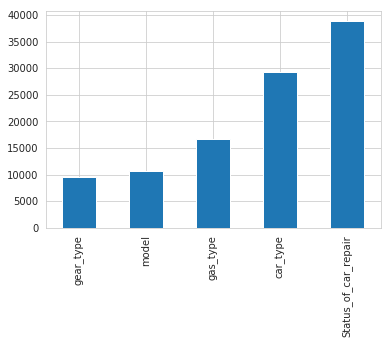

In [16]:
#missing values
sns.set_style("whitegrid")
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

In [24]:
# check number & percentage of missing value in the columns
def missing_values_table(df):
  mis_val = df.isnull().sum() #total missing values
  mis_val_percent = 100 * df.isnull().sum() / len(df) #percentage of missing values
  mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) #make a table with the results
  mis_val_table_ren_columns = mis_val_table.rename(
  columns = {0 : 'Missing Values', 1 : '% of Total Values'}) #rename the columns
     # sort the table by percentage of missing value
  mis_val_table_ren_columns = mis_val_table_ren_columns[
  mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        #print same summary information
  print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

          # return the dataframe with missing information
  return mis_val_table_ren_columns
  
missing_values = missing_values_table(train)
missing_values.head()

Your selected dataframe has 18 columns.
There are 5 columns that have missing values.


,Missing Values,% of Total Values
Status_of_car_repair,38865,16.600
car_type,29243,12.500
gas_type,16783,7.100
model,10703,4.600
gear_type,9501,4.000


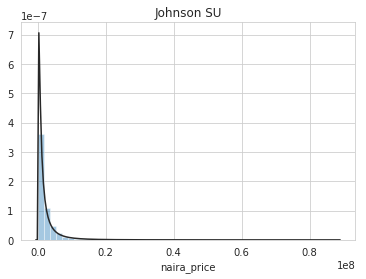

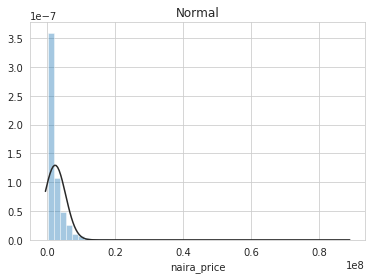

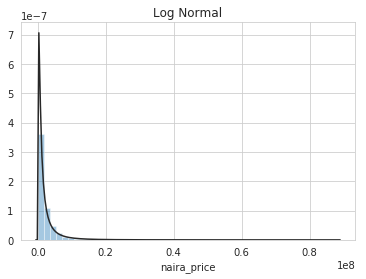

In [25]:
#handling the prize predictor varriable
y = train['naira_price']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)

In [0]:
max_price=max(train['naira_price'])
min_price=min(train['naira_price'])


In [30]:
max_price


88200000.0

In [29]:
min_price

180000.0

In [31]:
min_price/max_price

0.0020408163265306124